# Pneumonia Image Classification Project
**Author:** Kai Uechi

## Overview
The purpose of this project is to create a model that can identify the presense of pneumonia from chest x-rays. After iterating through multiple model designs, a convolutional neural network trained on the dataset was able to identify pneumonia in an infected patient's x-ray 95% of the time. This model has the potential to save significant time and money, as an evalutation of an x-ray by the model takes only 19 milliseconds on average. However, the model's performance could be improved with more x-rays to help balance the classes in the dataset.

## Business Problem
A radiology consultancy is looking to automate some of their work. While the consultancy as a whole specializes in providing detailed analyses of radiographs, a particularly common task for the consultancy is identifying cases of pneumonia from chest x-rays. Using neural networks, it may be possible to identify these cases more efficiently than is possible using manual analysis, saving both money and time.

## Data Understanding

This project's dataset consists of 5,856 chest x-rays collected from pediatric patients. Notably, of the 5,856 total images, 4,273 of the x-rays show a patient suffering from pneumonia. Although class imbalances are common in medical datasets, frequently the illness is the minority class rather than the other way around.

The images are greyscale, and the sizes and aspect ratios of the images vary.
Most images show the whole torso, but some are zoomed in on the lungs.

The cells below graph the class distribution and show a small sample of images from each category.

In [1]:
import os
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG19
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.ticker as mtick
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.segmentation import felzenszwalb, flood_fill, flood
from skimage.color import gray2rgb, rgb2gray
from os.path import exists
import time
np.random.seed(444)

In [2]:
n_train_normal = len(os.listdir('data/train/NORMAL'))
n_train_pneumonia = len(os.listdir('data/train/PNEUMONIA'))

n_test_normal = len(os.listdir('data/test/NORMAL'))
n_test_pneumonia = len(os.listdir('data/test/PNEUMONIA'))

n_val_normal = len(os.listdir('data/val/NORMAL'))
n_val_pneumonia = len(os.listdir('data/val/PNEUMONIA'))

n_total_normal = n_train_normal + n_test_normal + n_val_normal
n_total_pneumonia = n_train_pneumonia + n_test_pneumonia + n_val_pneumonia
n_total_all = n_total_normal + n_total_pneumonia
percentage_normal = n_total_normal/n_total_all
percentage_pneumonia = n_total_pneumonia/n_total_all

print('Total images:', n_total_all)
print('Total normal images:', n_total_normal)
print('Total pneumonia images:', n_total_pneumonia)
print('Train set counts (Normal, Pneumonia):', str(n_train_normal) + ',', n_train_pneumonia)
print('Test set counts (Normal, Pneumonia):', str(n_test_normal) + ',', n_test_pneumonia)
print('Validation set counts (Normal, Pneumonia):', str(n_val_normal) + ',', n_val_pneumonia)
print('Percentage image distribution (Normal, Pneumonia)', 
      "{:.2%}".format(percentage_normal) + ',', 
      "{:.2%}".format(percentage_pneumonia))

Total images: 5856
Total normal images: 1583
Total pneumonia images: 4273
Train set counts (Normal, Pneumonia): 1267, 3419
Test set counts (Normal, Pneumonia): 158, 427
Validation set counts (Normal, Pneumonia): 158, 427
Percentage image distribution (Normal, Pneumonia) 27.03%, 72.97%


Text(1.93, 0.7796789617486339, '72.97%')

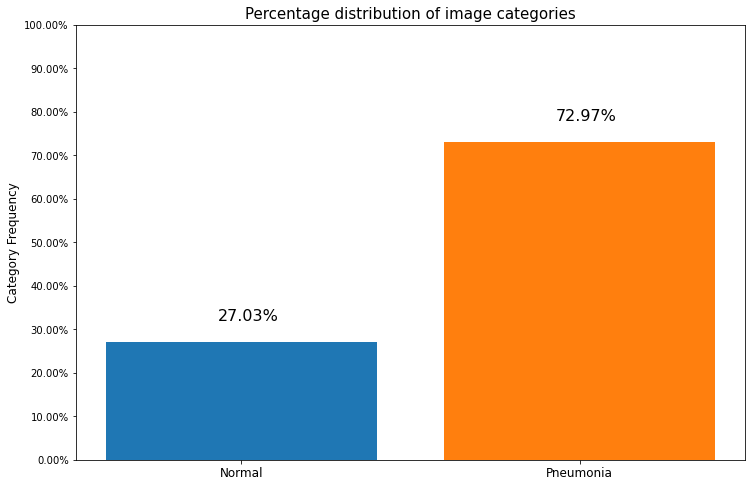

In [3]:
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(1, percentage_normal, label='Normal')
ax.bar(2, percentage_pneumonia, label='Pneumonia')
#ax.legend()
ax.set_title('Percentage distribution of image categories', fontsize=15)
plt.xticks([1,2],['Normal', 'Pneumonia'], fontsize=12)
plt.tick_params(
    axis='x',
    which='minor',
    bottom=False,
    top=False,
    labelbottom=False)
plt.ylabel('Category Frequency', fontsize=12)
plt.ylim(0, 1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=2))
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.text(1 -0.07, percentage_normal + 0.05, "{:.2%}".format(percentage_normal), fontsize=16)
plt.text(2 -0.07, percentage_pneumonia + 0.05, "{:.2%}".format(percentage_pneumonia), fontsize=16)

Text(0.5, 1.0, 'PNEUMONIA')

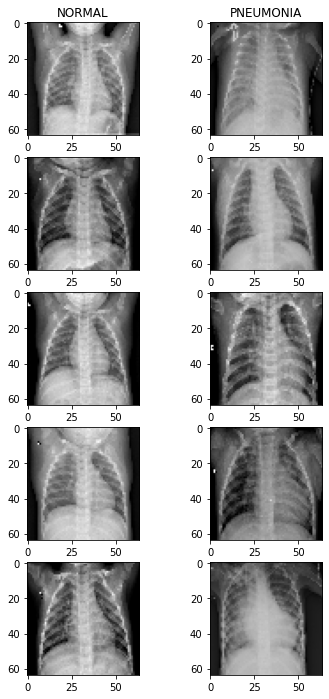

In [4]:
fig, ax = plt.subplots(figsize=(6,12), nrows=5, ncols=2)
ax[:, 0]

def showImgs(axList, path):
    w = 0
    for filename in os.listdir(path):
        if w < len(axList):
            #print(filename)
            img = load_img(path+filename, target_size=(64,64))
            axList[w].imshow(img)
            w += 1

showImgs(ax[:,0], 'data/train/NORMAL/')
showImgs(ax[:,1], 'data/train/PNEUMONIA/')
ax[0,0].set_title('NORMAL')
ax[0,1].set_title('PNEUMONIA')

## Data Preprocessing
The images have been arranged into train, test, and validation sets. The train set recieves 80% of the images, while test and validation sets each recieve 10%.

Next, the images are resized to the aspect ratios 512x512, 128x128, and 64x64. 
This ensures input consistency and allows for efficient training performance.

In the case of most models, only a subset of the images are used. This is done to allow for model iteration and tuning within a reasonable amount of time.

Some models also utilize data augmentation, which applies various transformations to the training set.

In [5]:
#check if images have already been resized
image_sizes = [512, 128, 64]

resized_set_sizes = []

stock_path = 'data/resized'

for size in image_sizes:
    image_counts = []
    resize_path = stock_path+str(size)+'/'
    #print(resize_path)
    for image_set in os.listdir(resize_path):
        set_path = resize_path + image_set + '/'
        #print(set_path)
        for folder in os.listdir(set_path):
            folder_path = set_path + folder + '/'
            folder_size = len(os.listdir(folder_path))
            #print(folder_path, folder_size)
            image_counts.append(folder_size)
    resized_set_sizes.append(image_counts)
    
#print(resized_set_sizes)

correct_set_sizes = [[158, 427, 1267, 3419, 158, 427], 
                     [158, 427, 1267, 3419, 158, 427], 
                     [158, 427, 1267, 3419, 158, 427]]

if resized_set_sizes == correct_set_sizes:
    images_resized = True
else:
    images_resized = False
    
print('Images already resized:', images_resized)

Images already resized: True


In [6]:
#if images haven't been resized, resize them
if images_resized == False:

    #data dirs
    train_dir = 'data/train'
    test_dir = 'data/test'
    val_dir = 'data/val'

    #image sizes aren't standard
    #preprocess and save to new dir
    dirs = [train_dir, test_dir, val_dir]



    for size in image_sizes:
        print('Resizing to', size)
        for data_dir in dirs:
            print('Starting on dir', data_dir)
            for folder in os.listdir(data_dir):
                new_path = data_dir + '/' + folder
                for img_path in os.listdir(new_path):
                    full_path = new_path + '/' + img_path
                    print(full_path)
                    preprocess_path = full_path[:8] + 'resized' + str(size) + '/' + full_path[8:]

                    img = Image.open(full_path)
                    new_width  = size
                    new_height = size
                    img = img.resize((new_width, new_height), Image.ANTIALIAS)
                    img.save(preprocess_path)
                    print(preprocess_path)
                    print('----------')

In [7]:
#choose image size to use
select_size=64

#choose batch size for each set
batch_size_train = 1600 #max is 4686
batch_size_test = 200   #max is 585
batch_size_val = 200    #max is 585

#new data dirs
train_dir = 'data/resized' + str(select_size) + '/train'
test_dir = 'data/resized' + str(select_size) + '/test'
val_dir = 'data/resized' + str(select_size) + '/val'

#create generators
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_dir, 
        target_size=(select_size, select_size), batch_size = batch_size_test,
        color_mode='grayscale') 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_dir, 
        target_size=(select_size, select_size), batch_size = batch_size_val,
        color_mode='grayscale')

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_dir, 
        target_size=(select_size, select_size), batch_size=batch_size_train,
        color_mode='grayscale')

Found 585 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 4686 images belonging to 2 classes.


In [8]:
#prepare dataset for baseline model
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

train_y = np.reshape(train_labels[:,1], (-1,1))
test_y = np.reshape(test_labels[:,1], (-1,1))
val_y = np.reshape(val_labels[:,1], (-1,1))

print(train_y.shape)
print(test_y.shape)
print(val_y.shape)

Number of training samples: 1600
Number of testing samples: 200
Number of validation samples: 200
train_images shape: (1600, 64, 64, 1)
train_labels shape: (1600, 2)
test_images shape: (200, 64, 64, 1)
test_labels shape: (200, 2)
val_images shape: (200, 64, 64, 1)
val_labels shape: (200, 2)
(1600, 4096)
(200, 4096)
(200, 4096)
(1600, 1)
(200, 1)
(200, 1)


Image Label: [1.]


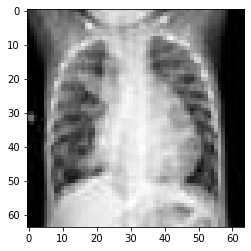

1.0    1169
0.0     431
dtype: int64

In [9]:
#check which category got which label
#in this case, normal is marked as 0 and pneumonia as 1
sample_image = train_images[180]
sample_label = train_y[180]
display(plt.imshow(sample_image, cmap='gray'))
print('Image Label: {}'.format(sample_label))
plt.show()


pd.DataFrame(train_y).value_counts()


## Modeling

### Baseline Model
The first model created is a simple densely connected neural network. This model is used to establish a baseline for model performance. Despite it's simplicity, this baseline model still managed to achieve 80% accuracy on the test set.

The graphs below show the change in the four tracked metrics (Accuracy, Recall, Precision, Loss) as the model trained. This set of graphs will be reproduced for each model to show their learning process.

In [10]:
#Call metrics seperately to avoid them being renamed when retraining
metric_recall = metrics.Recall()
metric_precision = metrics.Precision()

In [11]:
#Model history isn't saved as part of the .h5 file, so it needs to be saved seperately
def saveModelHistory(result_model, path):
    hist_df = pd.DataFrame(result_model.history)
    hist_json_file = path 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

In [12]:
#Baseline model
if exists('models/baseline.h5'):
    baseline = models.load_model('models/baseline.h5')
    baseline_history = pd.read_json('models/hist_baseline.json')
else:
    baseline = models.Sequential()
    baseline.add(layers.Dense(20, activation='relu', input_shape=(train_img.shape[1],))) 
    baseline.add(layers.Dense(7, activation='relu'))
    baseline.add(layers.Dense(5, activation='relu'))
    baseline.add(layers.Dense(1, activation='sigmoid'))

    baseline.compile(optimizer='sgd',
                  loss='binary_crossentropy',
                  metrics=[metric_recall, metric_precision, 'acc'])

    result_baseline = baseline.fit(train_img,
                            train_y,
                            epochs=40,
                            batch_size=32,
                            validation_data=(val_img, val_y))
    baseline_history = result_baseline.history


        
    saveModelHistory(result_baseline, 'models/hist_baseline.json')

7/7 [==============================] - 0s 1ms/step - loss: 0.6272 - recall: 0.9592 - precision: 0.8011 - acc: 0.7950


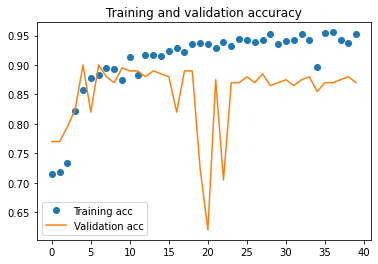

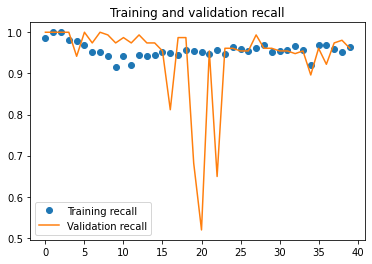

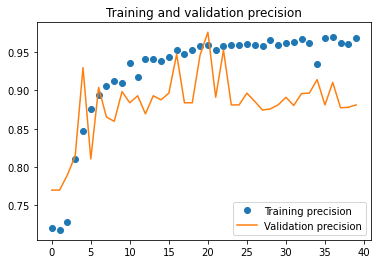

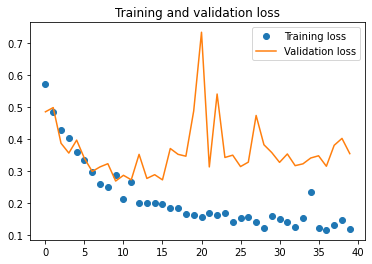

In [13]:
def plotResults(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    precision = history['precision']
    val_precision = history['val_precision']
    recall = history['recall']
    val_recall = history['val_recall']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'o', label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, recall, 'o', label='Training recall')
    plt.plot(epochs, val_recall, label='Validation recall')
    plt.title('Training and validation recall')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, precision, 'o', label='Training precision')
    plt.plot(epochs, val_precision, label='Validation precision')
    plt.title('Training and validation precision')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, loss, 'o', label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
    
baseline.evaluate(test_img, test_y)

plotResults(baseline_history)
baseline.save('models/baseline.h5')

### Basic Convolutional Model

The next model created is a convolutional neural network. Convolutional neural networks use filters to efficiently break down large images that would otherwise be unfeasable to train standard neural networks on.

As expected, this model's performance is superior to the baseline, although this new model is significantly slower to train.

In [14]:
#create conv model

if exists('models/conv1.h5'):
    model_conv = models.load_model('models/conv1.h5')
    conv_history = pd.read_json('models/hist_conv1.json')
else:
    model_conv = models.Sequential()
    model_conv.add(layers.Conv2D(32, (3, 3), activation='relu',
                            input_shape=(select_size, select_size, 1)))
    model_conv.add(layers.MaxPooling2D((2, 2)))

    model_conv.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model_conv.add(layers.MaxPooling2D((2, 2)))

    model_conv.add(layers.Conv2D(128, (5, 5), activation='relu'))
    model_conv.add(layers.MaxPooling2D((2, 2)))

    model_conv.add(layers.Flatten())
    model_conv.add(layers.Dense(800, activation='relu'))
    model_conv.add(layers.Dense(1, activation='sigmoid'))

    model_conv.compile(loss='binary_crossentropy',
                  optimizer="sgd",
                  metrics=[metric_recall, metric_precision, 'acc'])

    results_conv = model_conv.fit(train_images,
                                  train_y,
                                    epochs=20,
                                    batch_size=32,
                                    validation_data=(val_images, val_y))
    conv_history = results_conv.history

    saveModelHistory(results_conv, 'models/hist_conv1.json')

7/7 [==============================] - 0s 32ms/step - loss: 0.3882 - recall: 0.9456 - precision: 0.8528 - acc: 0.8400


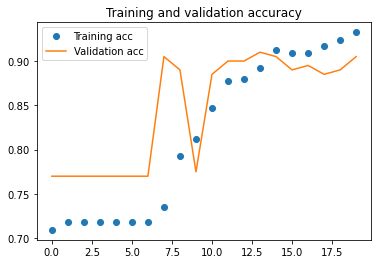

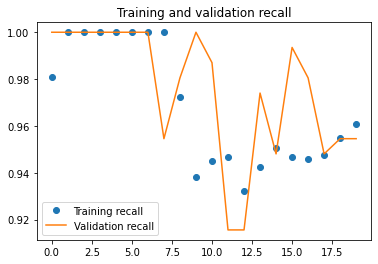

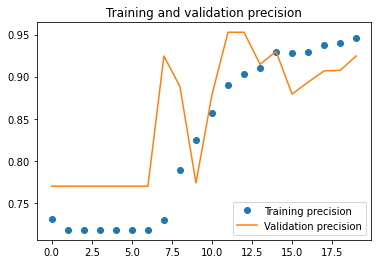

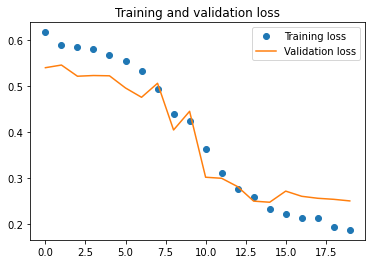

In [15]:
model_conv.evaluate(test_images, test_y)
plotResults(conv_history)

model_conv.save('models/conv1.h5')

### Convolutional Model with Data Augmentation

The previous convolutional model improved over the baseline, but only slightly. The objective with this new convolutional model is to tweak it's parameters to improve performance. 

An additional hidden layer is added, and the model now uses data augmentation on the test set. This data augmentation randomly applies transformations to the images to help make the most of the small training subset. The effect of these transformations is visible in the 3 image samples below. Additionally, this model uses early stopping and model checkpoint callbacks to make the training process more efficient.

Ultimately, these changes allowed this model to perform better than the previous convolutional model, making this model the best performing so far.

In [16]:
#setup data augmentation
train_gen_aug = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)

train_aug_generator = train_gen_aug.flow_from_directory(
        train_dir, 
        target_size=(select_size, select_size), batch_size=batch_size_train,
        color_mode='grayscale')

train_aug_images, train_aug_labels = next(train_generator)
train_aug_y = np.reshape(train_aug_labels[:,1], (-1,1))


Found 4686 images belonging to 2 classes.


data/resized64/train/NORMAL/IM-0115-0001.jpeg


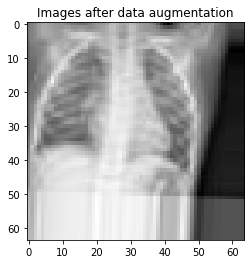

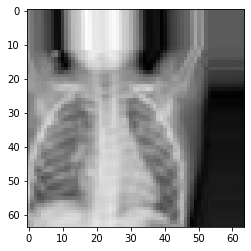

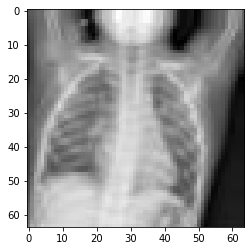

In [17]:
aug_show_dir = train_dir + '/' + os.listdir(train_dir)[0] + '/'
aug_show_dir = aug_show_dir + os.listdir(aug_show_dir)[0]
print(aug_show_dir)

img = load_img(aug_show_dir, target_size=(select_size, select_size))

reshape_img = img_to_array(img) 
reshape_img = reshape_img.reshape((1,) + reshape_img.shape) 
w=0
for batch in train_gen_aug.flow(reshape_img, batch_size=1):
    plt.figure(w)
    imgplot = plt.imshow(array_to_img(batch[0]))
    if w == 0:
        plt.title('Images after data augmentation')
    w += 1
    if w % 3 == 0:
        break
        

plt.show()

In [18]:
#setup early stopping
early_stopping = [EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True), 
                  ModelCheckpoint(filepath='models/checkpointTemp.h5', monitor='val_loss', save_best_only=True)]


In [19]:
if exists('models/convDataAug.h5'):
    model_conv_aug = models.load_model('models/convDataAug.h5')
    conv_aug_history = pd.read_json('models/hist_convDataAug.json')
else:
    model_conv_aug = models.Sequential()
    model_conv_aug.add(layers.Conv2D(32, (3, 3), activation='relu',
                            input_shape=(select_size, select_size, 1)))
    model_conv_aug.add(layers.MaxPooling2D((2, 2)))

    model_conv_aug.add(layers.Conv2D(64, (3, 3),
                                     activation='relu'))
    model_conv_aug.add(layers.MaxPooling2D((2, 2)))

    model_conv_aug.add(layers.Conv2D(128, (5, 5),
                                     activation='relu'))
    model_conv_aug.add(layers.MaxPooling2D((2, 2)))

    model_conv_aug.add(layers.Flatten())
    model_conv_aug.add(layers.Dense(800, activation='relu'))
    model_conv_aug.add(layers.Dense(400, activation='relu'))
    model_conv_aug.add(layers.Dense(1, activation='sigmoid'))

    model_conv_aug.compile(loss='binary_crossentropy',
                           optimizer="sgd",
                           metrics=[metric_recall, metric_precision, 'acc'])

    results_conv_aug = model_conv_aug.fit(train_aug_images,
                                          train_aug_y,
                                          epochs=30,
                                          batch_size=32,
                                          validation_data=(val_images, val_y),
                                          callbacks=early_stopping)
    conv_aug_history = results_conv_aug.history

    saveModelHistory(results_conv_aug, 'models/hist_convDataAug.json')

7/7 [==============================] - 0s 31ms/step - loss: 0.3298 - recall: 0.9388 - precision: 0.8625 - acc: 0.8450


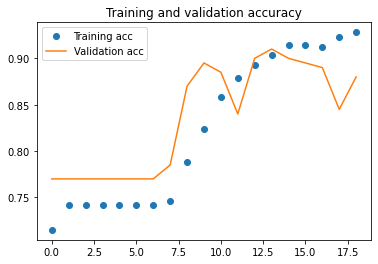

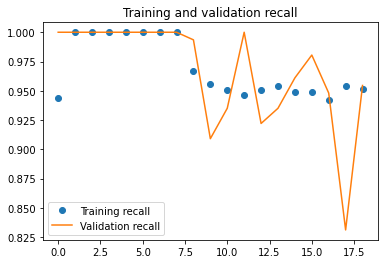

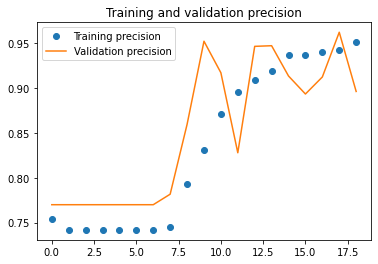

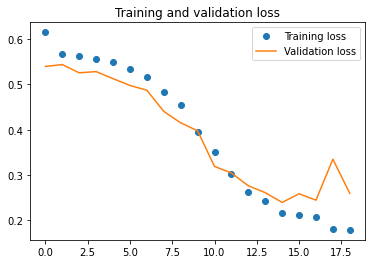

In [20]:
model_conv_aug.evaluate(test_images, test_y)
plotResults(conv_aug_history)
model_conv_aug.save('models/convDataAug.h5')

### Transfer Learning: Feature Extraction

This model takes a different approach from the previous convolutional models: This model uses a pretrained model to process the images in the hopes of leveraging the existing models ability and applying it to a new task.

Because the pretrained model only accepts colored images, some additonal data preprocessing is required. Like the previous convolutional model, this model uses data augmentation as well as early stopping and model checkpoints.

Unfortunately, this model's performance is worse than the previous models, and fails to meet the baseline.

In [21]:
#setup feature extraction
#load images in color

test_generator_color = train_gen_aug.flow_from_directory(
        test_dir, 
        target_size=(select_size, select_size), batch_size = batch_size_test) 

val_generator_color = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_dir, 
        target_size=(select_size, select_size), batch_size = batch_size_val)

train_generator_color = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_dir, 
        target_size=(select_size, select_size), batch_size=batch_size_train)

train_images_color, train_labels_color = next(train_generator_color)
test_images_color, test_labels_color = next(test_generator_color)
val_images_color, val_labels_color = next(val_generator_color)

train_y_color = np.reshape(train_labels_color[:,1], (-1,1))
test_y_color = np.reshape(test_labels_color[:,1], (-1,1))
val_y_color = np.reshape(val_labels_color[:,1], (-1,1))




#load model

vgg = VGG19(weights='imagenet',
           include_top=False,
           input_shape=(select_size, select_size, 3))

vgg.trainable = False

Found 585 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 4686 images belonging to 2 classes.


In [22]:
if exists('models/transfer1.h5'):
    model_transfer = models.load_model('models/transfer1.h5')
    transfer_history = pd.read_json('models/hist_transfer1.json')
else:
    model_transfer = models.Sequential()
    model_transfer.add(vgg)

    model_transfer.add(layers.Flatten())
    model_transfer.add(layers.Dense(512, activation='relu'))
    model_transfer.add(layers.Dense(1, activation='sigmoid'))

    model_transfer.compile(loss='binary_crossentropy',
                           optimizer="sgd",
                           metrics=[metric_recall, metric_precision, 'acc'])

    for layer in model_transfer.layers:
        print(layer.name, 'Trainable:', layer.trainable)

    results_transfer = model_transfer.fit(train_images_color,
                                          train_y_color,
                                          epochs=15,
                                          batch_size=128,
                                          validation_data=(val_images_color, val_y_color),
                                          callbacks=early_stopping)
    transfer_history = results_transfer.history

    saveModelHistory(results_transfer, 'models/hist_transfer1.json')

7/7 [==============================] - 6s 873ms/step - loss: 0.5830 - recall: 1.0000 - precision: 0.7449 - acc: 0.7500


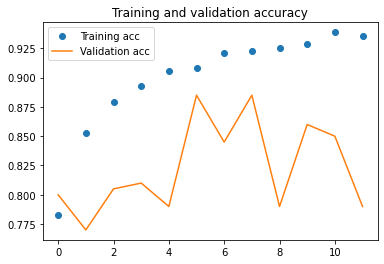

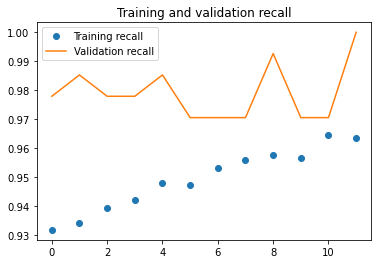

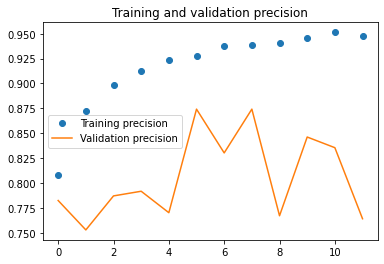

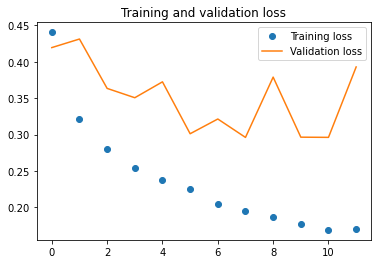

In [23]:
model_transfer.evaluate(test_images_color, test_y_color)
plotResults(transfer_history)
model_transfer.save('models/transfer1.h5')

### Transfer learning: Fine Tuning

Although the previous model using transfer learning performed poorly, it's possible that through fine tuning this approach could be improved. Fine tuning requires that the later layers of a pretrained model are retrained on the current data, while the earlier layers remain frozen. While this process tends to be powerful, it is also very computationally demanding.

In this case, using fine tuning did improve performance compared to the feature extraction model. However, although improved from the previous model, this model's performance is still below the convolutional model using data augmentation. 

In [24]:
vgg_tune = VGG19(weights='imagenet',
           include_top=False,
           input_shape=(select_size, select_size, 3))


for layer in vgg_tune.layers:
    if 'block5' not in layer.name:
        layer.trainable = False
        
for layer in vgg_tune.layers:
    print(layer.name, 'Trainable:', layer.trainable)

input_2 Trainable: False
block1_conv1 Trainable: False
block1_conv2 Trainable: False
block1_pool Trainable: False
block2_conv1 Trainable: False
block2_conv2 Trainable: False
block2_pool Trainable: False
block3_conv1 Trainable: False
block3_conv2 Trainable: False
block3_conv3 Trainable: False
block3_conv4 Trainable: False
block3_pool Trainable: False
block4_conv1 Trainable: False
block4_conv2 Trainable: False
block4_conv3 Trainable: False
block4_conv4 Trainable: False
block4_pool Trainable: False
block5_conv1 Trainable: True
block5_conv2 Trainable: True
block5_conv3 Trainable: True
block5_conv4 Trainable: True
block5_pool Trainable: True


In [25]:

if exists('models/transfer2.h5'):
    model_transfer_tune = models.load_model('models/transfer2.h5')
    transfer_tune_history = pd.read_json('models/hist_transfer2.json')
else:
    model_transfer_tune = models.Sequential()
    model_transfer_tune.add(vgg_tune)

    model_transfer_tune.add(layers.Flatten())
    model_transfer_tune.add(layers.Dense(1024, activation='relu'))
    model_transfer_tune.add(layers.Dense(1, activation='sigmoid'))

    model_transfer_tune.compile(loss='binary_crossentropy',
                           optimizer="sgd",
                           metrics=[metric_recall, metric_precision, 'acc'])


    results_transfer_tune = model_transfer_tune.fit(train_images_color,
                                               train_y_color,
                                               epochs=30,
                                               batch_size=128,
                                               validation_data=(val_images_color, val_y_color),
                                               callbacks=early_stopping)
    transfer_tune_history = results_transfer_tune.history

    saveModelHistory(results_transfer_tune, 'models/hist_transfer2.json')

7/7 [==============================] - 6s 867ms/step - loss: 0.4148 - recall: 0.9863 - precision: 0.8045 - acc: 0.8150


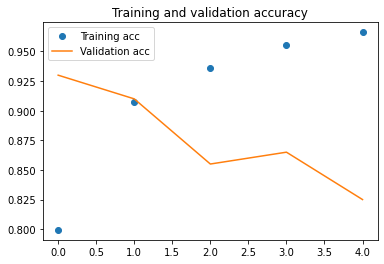

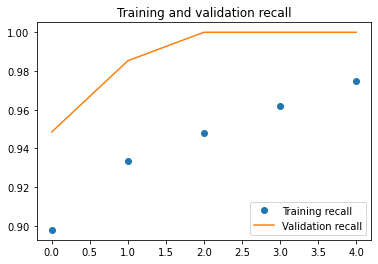

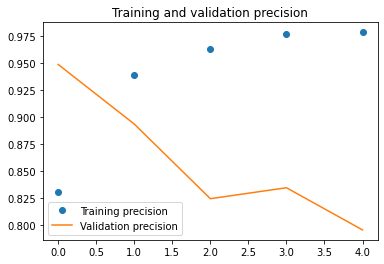

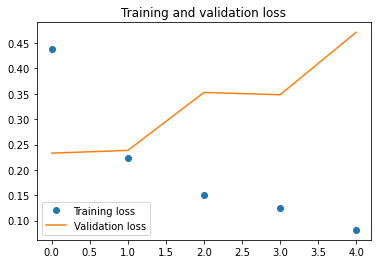

In [26]:
model_transfer_tune.evaluate(test_images_color, test_y_color)
plotResults(transfer_tune_history)
model_transfer_tune.save('models/transfer2.h5')

### Final Model

The final model is based on the convolutional model utilizing data augmentation since it is the model with the best performance so far. This new model is trained on 128x128 sized images rather than 64x64, so the final model is given additional layers as well as larger layers overall in order to compensate for this. 

Additionally, the final model is trained and validated on the entire data set, rather than a subset. Like before, this model uses data augmentation, but now also uses stochastic batching to allow the model to converge in a reasonable amount of time.

Although it takes a long time to train, this final model has managed to improve over the previous best model.

In [27]:
#Setup final model
#set params for final model
select_size_final=128

#choose batch size for each set
batch_size_train_final = 4686 #max is 4686
batch_size_test_final = 585   #max is 585
batch_size_val_final = 585    #max is 585

#new data dirs
train_dir = 'data/resized' + str(select_size_final) + '/train'
test_dir = 'data/resized' + str(select_size_final) + '/test'
val_dir = 'data/resized' + str(select_size_final) + '/val'

#create generators

train_gen_aug = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_dir, 
        target_size=(select_size_final, select_size_final), batch_size = batch_size_test_final,
        color_mode='grayscale') 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_dir, 
        target_size=(select_size_final, select_size_final), batch_size = batch_size_val_final,
        color_mode='grayscale')

train_generator = train_gen_aug.flow_from_directory(
        train_dir, 
        target_size=(select_size_final, select_size_final), batch_size=batch_size_train_final,
        color_mode='grayscale')


train_images_final, train_labels_final = next(train_generator)
test_images_final, test_labels_final = next(test_generator)
val_images_final, val_labels_final = next(val_generator)


train_y_final = np.reshape(train_labels_final[:,1], (-1,1))
test_y_final = np.reshape(test_labels_final[:,1], (-1,1))
val_y_final = np.reshape(val_labels_final[:,1], (-1,1))

pd.DataFrame(train_y_final).value_counts()

Found 585 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 4686 images belonging to 2 classes.


1.0    3419
0.0    1267
dtype: int64

In [28]:
early_stopping_final = [EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True), 
                        ModelCheckpoint(filepath='models/checkpointTemp.h5', monitor='val_loss', save_best_only=True)]


In [29]:
if exists('models/final.h5'):
    model_final = models.load_model('models/final.h5')
    final_history = pd.read_json('models/hist_final.json')
else:
    model_final = models.Sequential()
    model_final.add(layers.Conv2D(64, (3, 3), activation='relu',
                            input_shape=(select_size_final, select_size_final, 1)))
    model_final.add(layers.MaxPooling2D((2, 2)))

    model_final.add(layers.Conv2D(128, (3, 3),
                                     activation='relu'))
    model_final.add(layers.MaxPooling2D((2, 2)))
    
    model_final.add(layers.Conv2D(256, (3, 3),
                                     activation='relu'))
    model_final.add(layers.MaxPooling2D((2, 2)))

    model_final.add(layers.Conv2D(512, (3, 3),
                                     activation='relu'))
    model_final.add(layers.MaxPooling2D((2, 2)))
    
    model_final.add(layers.Conv2D(1024, (3, 3),
                                     activation='relu'))
    model_final.add(layers.MaxPooling2D((2, 2)))
    
    model_final.add(layers.Flatten())
    model_final.add(layers.Dense(2048, activation='relu'))
    model_final.add(layers.Dense(1, activation='sigmoid'))

    model_final.compile(loss='binary_crossentropy',
                           optimizer="sgd",
                           metrics=[metric_recall, metric_precision, 'acc'])
    model_final.summary()
    results_final = model_final.fit(train_images_final,
                                          train_y_final,
                                          epochs=20,
                                          batch_size=1,
                                          validation_data=(val_images_final, val_y_final),
                                          callbacks=early_stopping_final)
    final_history = results_final.history

    saveModelHistory(results_final, 'models/hist_final.json')

19/19 [==============================] - 11s 557ms/step - loss: 0.3218 - recall: 0.9368 - precision: 0.9132 - acc: 0.8889


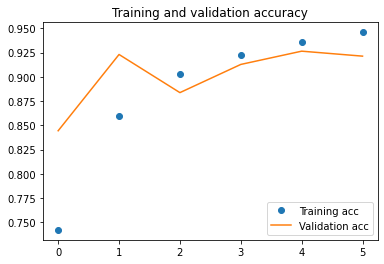

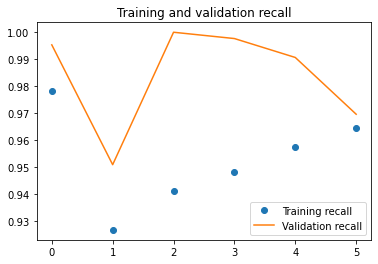

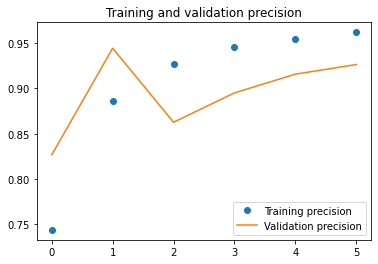

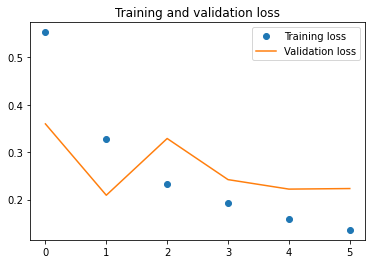

In [30]:
model_final.evaluate(test_images_final, test_y_final)
plotResults(final_history)
model_final.save('models/final.h5')

## Conclusion

### Model Evaluation

When evaluated on it's test set, the final model achieved superior scores compared to previous models. In general, these scores tended to be just above the Convolutional w/ Data Augmentation model that the final model was based on. The points below discuss the details of the final model's performance:

* Loss:
    * The final model achieved a loss of 0.32, the best loss overall. 
    * This is an improvement of 0.01 over the next best score.
* Recall:
    * The final model's recall score is 0.93, the lowest of all models. 
    * However, although the final model's recall score is lower, its superior performance in other metrics allows it to achieve a better balance of recall and precision.
* Precision:
    * The final model achieved a precision score of 0.91, the best by a significant margin. 
    * Compared to the Convolutional w/ Data Augmentation model, the final model's precision is 0.05 greater.
* Accuracy:
    * The final model's accuracy score is 0.89, once again the best out of all of the models.
    * The next highest accuracy score is 0.85

The graphs below visualize the performance of each model by metric. The final model is marked in red.

In [31]:
model_scores = {
    'Baseline' : baseline.evaluate(test_img, test_y),
    'Basic Convolutional' : model_conv.evaluate(test_images, test_y),
    'Convolutional w/ Augmentation' : model_conv_aug.evaluate(test_images, test_y),
    'Feature Extraction' : model_transfer.evaluate(test_images_color, test_y_color),
    'Fine Tuning' : model_transfer_tune.evaluate(test_images_color, test_y_color),
    'Final Model' : model_final.evaluate(test_images_final, test_y_final)
}

19/19 [==============================] - 10s 536ms/step - loss: 0.3218 - recall: 0.9368 - precision: 0.9132 - acc: 0.8889


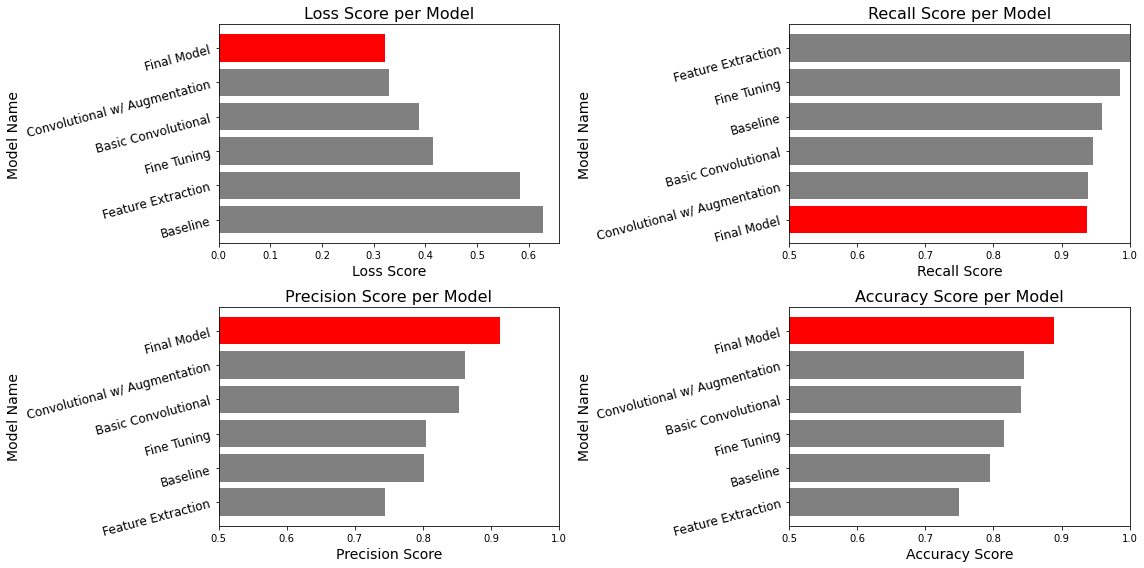

In [32]:
metric_list = ['Loss', 'Recall', 'Precision', 'Accuracy']
w = 0

fig, ax = plt.subplots(figsize=(16,8), nrows=2, ncols=2)
ax_list = ax.flatten()

for metric in metric_list:
    dfFind1 = pd.DataFrame([(x[w] for x in model_scores.values())], columns=model_scores.keys())
    dfFind1 = dfFind1.T
    dfFind1.columns = [metric]
    
    if w == 0:
        dfFind1.sort_values(by=metric, ascending=False, inplace=True)
    else:
        dfFind1.sort_values(by=metric, ascending=True, inplace=True)
        
    if w != 1:
        color_list = ['gray','gray','gray','gray','gray','r']
    else:
        color_list = ['r','gray','gray','gray','gray','gray']
    
    barList = ax_list[w].barh((range(len(model_scores))), 
                              dfFind1[metric], 
                              align='center',
                             color=color_list)

    ax_list[w].set_yticks(np.arange(len(model_scores)))
    ax_list[w].set_yticklabels(dfFind1.index, rotation=15, fontsize=12)
    if w != 0:
        ax_list[w].set_xlim(0.5, 1.0)

    ax_list[w].set_title(metric + ' Score per Model', fontsize=16)
    ax_list[w].set_ylabel('Model Name', fontsize=14)
    ax_list[w].set_xlabel(metric + ' Score', fontsize=14)
    #ax_list[w].invert_xaxis()
    w += 1
    
fig.tight_layout()

### Decision Threshold Tuning

Although the final model performs well, simply focusing on loss or accuracy is not appropriate given that the business problem is of a medical context. In this case, a false positive is prefered to a false negative. Considering this, a custom decision threshold is used to further tune the model's predictions. Ultimately, a threshold of `0.37` was chosen to maintain good precision while having very high recall. 

The cell below calculates the effects of this decision threshold, allowing the model to achieve a recall score of `0.95` while still maintaining a precision score of `0.88`.

The graph further below visualizes the effects of various decision thresholds on the model's precision and recall.

In [33]:
#Set threshold
threshold = 0.37
predictions_raw = model_final.predict(test_images_final)
preds = []
for val in predictions_raw:
    if val > threshold:
        preds.append(1)
    else:
        preds.append(0)
        
print('Final model scores w/ custom decision threshold')
print('Recall:', recall_score(test_y_final, preds))
print('Precision:', precision_score(test_y_final, preds))
print('Accuracy:', accuracy_score(test_y_final, preds))

Final model scores w/ custom decision threshold
Recall: 0.9531615925058547
Precision: 0.8828633405639913
Accuracy: 0.8735042735042735


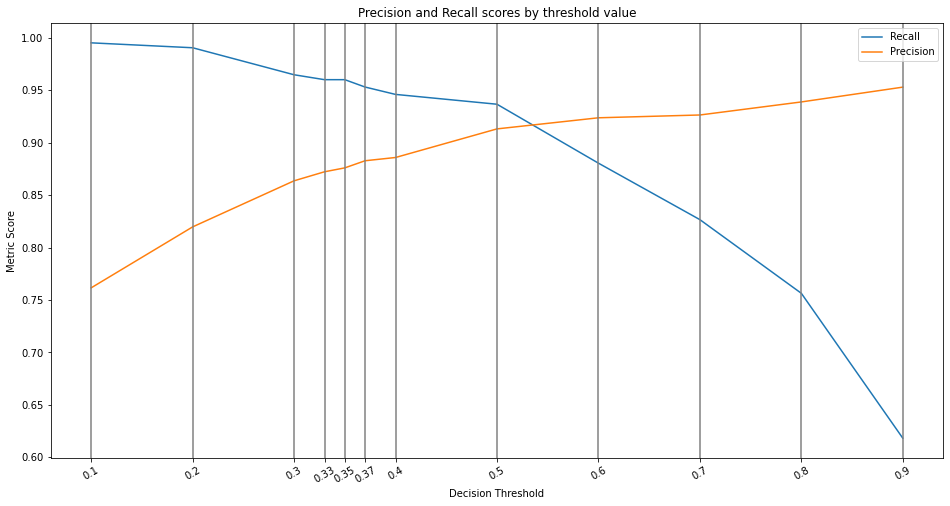

In [34]:
threshold_list = [0.1,0.2,0.3,0.33,0.35,0.37,0.4,0.5,0.6,0.7,0.8,0.9]

thresh_results = {}
for threshold in threshold_list:
    preds = []
    for val in predictions_raw:
        if val > threshold:
            preds.append(1)
        else:
            preds.append(0)
    thresh_results[threshold] = preds

thresh_recall = {}
thresh_precision = {}

for key in thresh_results.keys():
    thresh_recall[key] = recall_score(test_y_final, thresh_results[key])
    thresh_precision[key] = precision_score(test_y_final, thresh_results[key])
    
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(thresh_results.keys(), thresh_recall.values(), label='Recall')
ax.plot(thresh_results.keys(), thresh_precision.values(), label='Precision')

ax.set_ylabel('Metric Score')
ax.set_xlabel('Decision Threshold')
for key in thresh_results.keys():
    ax.axvline(key, color='gray')
    
ax.set_xticks(threshold_list)
ax.set_xticklabels(threshold_list, rotation=30)
    
ax.set_title('Precision and Recall scores by threshold value')
plt.legend()

### Model Efficiency Compared to Human Evaluation

For the specific task of identifying pneumonia from a chest x-ray, a trained radiologist could likely complete an evaluation in a matter of seconds. Even so, the speed of the final model far exceeds human capability.

A human could likely complete evaluations with an average time as fast as 2 seconds. The final model, on the other hand, can evaluate all 585 images in the test set in around 11 seconds. This gives the model an average speed of approximately 19 milliseconds per image, making the model 105 times faster than a human radiologist.

The graph below visualizes how many evaluations a human and the final model would each be able to complete in 1 minute.

Total images in test set: 585
Total time to process: 10.82 seconds
Model average time per image: 0.018494509427975387


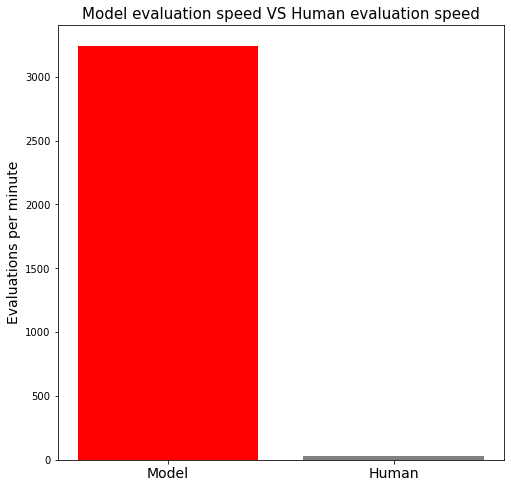

In [35]:
print('Total images in test set:', len(test_images_final))

tmp = time.time()

model_final.predict(test_images_final)

total_time = time.time() - tmp

print('Total time to process:', '{:.2f}'.format(total_time), 'seconds')

model_average_time = total_time/len(test_images_final)
human_average_time = 2.0
print('Model average time per image:', model_average_time)

model_total_minute = 60/model_average_time
human_total_minute = 60/human_average_time
fig, ax = plt.subplots(figsize=(8,8))
ax.bar([1,2], [model_total_minute, human_total_minute], color=['r', 'gray'])
ax.set_ylabel('Evaluations per minute', fontsize=14)
ax.set_title('Model evaluation speed VS Human evaluation speed', fontsize=15)
ax.set_xticks([1,2])
ax.set_xticklabels(['Model', 'Human'], fontsize=14)
plt.tick_params(
    axis='x',
    which='minor',
    bottom=False,
    top=False,
    labelbottom=False)

### Model Deployment Considerations

The performance of the final model is very good, as it can detect a case of pneumonia 95% of the time, with a false positive rate of only 12%. With this sort of identification ability, the model could be effectively deployed for use. Doing so would save the consultancy both money and time.

The model could be used internally by consultancy radiologists to quickly identify cases of pneumonia. Additionally, radiologists could view the model's raw predictions before they are put through the decision threshold. That way, radiologists would be able to focus on manually checking the predictions that the model is least confident in.

Alternatively, if the model is deployed as a webapp, customers who send in x-rays to be analyzed by the consultancy could instead send their data directly to the model. The benefit of this is that customers would recieve results almost instantly, without requiring the direct action of consultancy radiologists. It is important to note, however, that this particular method of deployment raises security concerns. Therefore, if deploying the model as a webapp, the consultancy would need to ensure patient medical data is secure while being sent online.

### Next Steps
* **Gather more data**
    * The model's perfomance could be improved further with additional labeled data to train on. X-rays of healthy patients should be prioritized, as this will address the class imbalance that currently exists in the dataset.
* **Purchase/rent more computing resources**
    * With currently available computing power, tuning the parameters of the model further will be difficult and time consuming. Given more resouces, however, further tuning could improve the model.
* **Collect data on other illnesses**
    * The performance of the final model is promising. It's likely that other illnesses could be identified by machine vision with similar effectiveness. Therefore, data on additional illnesses should be collected for use with future models.